In [1]:
%matplotlib inline

In [2]:
import pandas as pd
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Your code here

# Reset warning settings (optional, if you want to re-enable warnings)
# warnings.resetwarnings()

In [3]:
import matplotlib.pyplot as plt
# plt.style.use('fivethirtyeight')

In [4]:
timeparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M')

In [5]:
df = pd.read_csv('new_columndata.csv')
df_new = pd.read_csv('mean_data.csv')

In [6]:
df['datetime'] = pd.to_datetime(df['datetime'])

In [7]:
df['hour'] = df['datetime'].apply(lambda x: x.hour)

<Axes: xlabel='hour'>

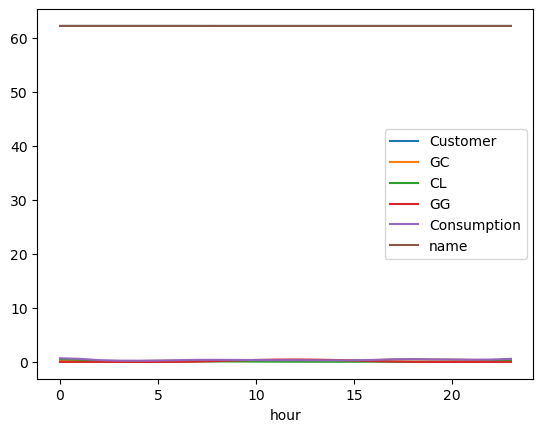

In [8]:
df.groupby('hour').mean().plot()

In [9]:
df.describe()

,Customer,GC,CL,GG,Consumption,name,hour
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,6.224998e+01,2.891677e-01,1.043553e-01,1.261518e-01,3.935230e-01,6.224998e+01,1.149988e+01
std,3.940037e+01,3.313388e-01,3.914127e-01,2.650571e-01,5.081445e-01,3.940037e+01,6.922215e+00
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,2.900000e+01,1.030000e-01,0.000000e+00,0.000000e+00,1.110000e-01,2.900000e+01,5.000000e+00
50%,6.100000e+01,1.900000e-01,0.000000e+00,0.000000e+00,2.140000e-01,6.100000e+01,1.100000e+01
75%,9.600000e+01,3.380000e-01,0.000000e+00,1.690000e-01,4.190000e-01,9.600000e+01,1.700000e+01
max,1.290000e+02,6.567000e+00,3.844000e+00,4.331000e+00,6.588000e+00,1.290000e+02,2.300000e+01


<Axes: xlabel='hour'>

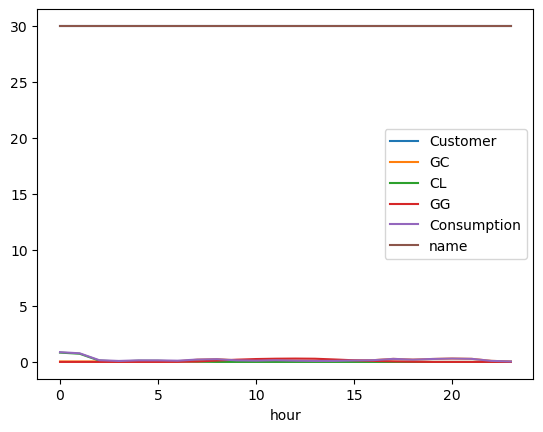

In [10]:
df[df.Customer == 30].groupby('hour').mean().plot()

<Axes: xlabel='hour'>

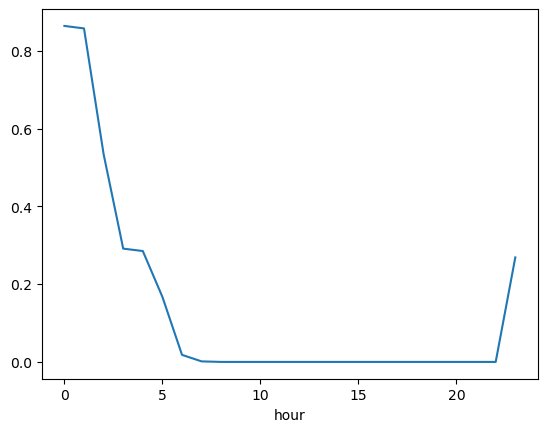

In [11]:
df[df.Customer == 1].groupby('hour').apply('CL').mean().plot()

In [12]:
customers = sorted(df.Customer.unique())

In [13]:
customers

[1,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 14,
 15,
 18,
 19,
 23,
 29,
 30,
 35,
 36,
 37,
 39,
 41,
 42,
 43,
 49,
 51,
 53,
 54,
 56,
 59,
 61,
 64,
 65,
 66,
 69,
 70,
 71,
 73,
 75,
 77,
 81,
 84,
 87,
 88,
 94,
 96,
 98,
 99,
 105,
 107,
 108,
 110,
 112,
 118,
 119,
 122,
 123,
 125,
 126,
 127,
 129]

<Axes: xlabel='hour'>

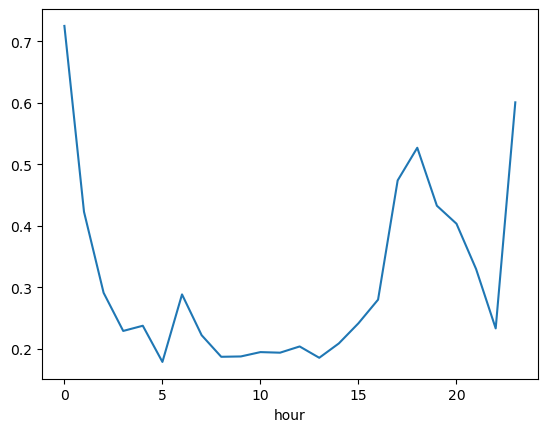

In [14]:
df[df.Customer == 5].groupby('hour').apply('Consumption').mean().plot()

In [21]:
def multiline_hourly_plot(dataset, avg = None, ycol = 'GC', ymin = None, ymax = None, opacity = None, title = None):
    fig, ax = plt.subplots()
    
    if ymin is not None:
        ax.set_ylim(bottom = ymin)
    
    if ymax is not None:
        ax.set_ylim(top = ymax)
        
    if opacity is None:
        opacity = 0.01

    for key, group in dataset:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
    if avg is not None:
        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
    if title is not None:
        ax.set_title(title)

    ax.legend().set_visible(False) # Disable the plot legend
    plt.show()

In [17]:
# multiline_hourly_plot(df.groupby('Customer'))

In [18]:
df['day'] = df['datetime'].apply(lambda x: x.timetuple().tm_yday)

In [19]:
bld_df = df[(df.Customer == 15)]

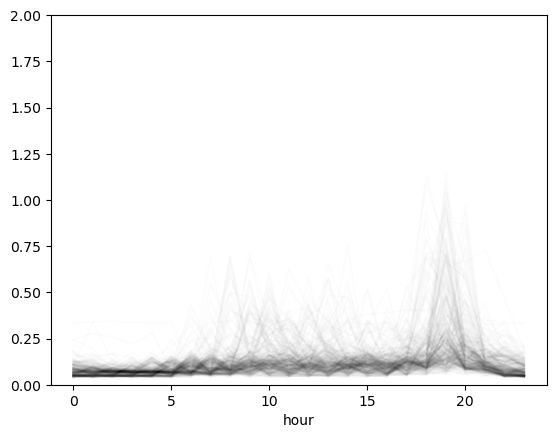

In [23]:
multiline_hourly_plot(bld_df.groupby('day'), ymax = 2)

In [24]:
df['weekday'] = df['datetime'].apply(lambda x: x.weekday() < 5)

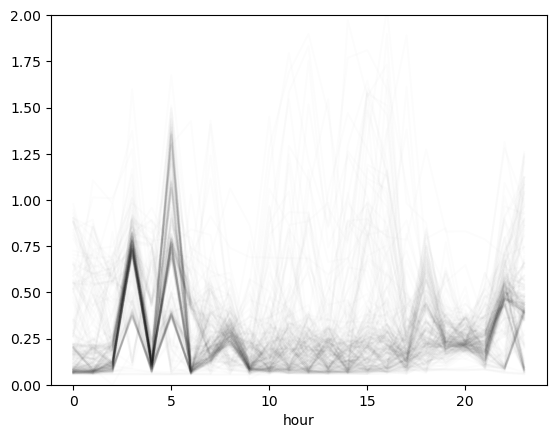

In [25]:
# We need to redefine bld_df because we added a new column to df...
# this was not automatically "imported" into bld_df
bld_df = df[(df.Customer == 1)]
multiline_hourly_plot(bld_df[bld_df.weekday == True].groupby('day'), ymax = 2)

In [26]:
df_5 = bld_df[(bld_df.hour == 5) & (bld_df.GC<0.5)]
import calendar # To have human-readable names for the days of the week
df_5['datetime'].apply(lambda x: calendar.day_name[x.weekday()]).value_counts()

Saturday     26
Monday       26
Friday       24
Tuesday      23
Wednesday    23
Thursday     22
Sunday       21
Name: datetime, dtype: int64

In [27]:
df['max_energy'] = df.groupby(['Customer'])['GC'].transform(max)

In [28]:
df['norm_energy'] = df['GC'] / df['max_energy']


In [29]:
import numpy as np
from scipy.spatial.distance import cdist
from sklearn import cluster 

In [30]:
red_df = df[['Customer', 'day', 'hour', 'norm_energy']]
piv_df = pd.pivot_table(red_df, index = ['Customer', 'day'], columns = 'hour', values = 'norm_energy')
piv_df.reset_index(inplace = True)
grp_df = piv_df.groupby(['Customer']).median()
grp_df.reset_index(inplace = True)
del grp_df['day'] # This feature is not relevant any more
# piv_df
# grp_df

In [31]:
df['Customer'].unique().size

60

In [32]:
def elbow_method(dataframe, min_k, max_k):
    # Try all k's between min_k and max_k
    cluster_nums = range(min_k, max_k + 1)
    
    # Array of K-means algorithm objects
    k_mean_algs = [cluster.KMeans(n_clusters = k) for k in cluster_nums]
    
    # Array with the results of the K-mean algorithms
    k_mean_res = [alg.fit(dataframe) for alg in k_mean_algs]
    
    # Array with the centroids for each value of k
    centroids = [res.cluster_centers_ for res in k_mean_res]
    
    # Euclidean distance between the points of the cluster and the centroids
    distances = [cdist(dataframe, centroid, 'euclidean') for centroid in centroids]
    
    # Get the closest centroid (and the corresponding distance)
    min_indices = [np.argmin(distance, axis = 1) for distance in distances]
    min_distances = [np.min(distance, axis = 1) for distance in distances]
    
    # Calculate the average squared distance
    avg_sum_squares = [sum(dist ** 2) / kmeans_df.shape[0] for dist in min_distances]

    # Plot the elbow graph
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(cluster_nums, avg_sum_squares, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average sum of squares within cluster')
    plt.show()
    
    return (k_mean_algs, k_mean_res)

In [33]:
kmeans_df = grp_df
kmeans_df

hour,Customer,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,0.057031,0.048884,0.057812,0.329018,0.050893,0.338951,0.049219,0.084933,0.118750,...,0.065625,0.088728,0.089062,0.075893,0.123103,0.103795,0.103460,0.095759,0.213616,0.183929
1,3,0.031631,0.029217,0.028201,0.027947,0.027947,0.028773,0.029980,0.027947,0.028328,...,0.035061,0.034045,0.035442,0.036712,0.036839,0.035823,0.035569,0.037729,0.043064,0.034426
2,4,0.034911,0.034156,0.033904,0.034156,0.034156,0.033652,0.034240,0.035247,0.041457,...,0.055639,0.080396,0.094411,0.101292,0.096341,0.080690,0.061598,0.050185,0.046912,0.042128
3,5,0.034004,0.032174,0.031565,0.030192,0.029963,0.030040,0.033928,0.033471,0.039799,...,0.042238,0.046279,0.052569,0.068009,0.101708,0.100259,0.093626,0.081122,0.059927,0.040332
4,6,0.083959,0.078651,0.077997,0.080284,0.083306,0.087104,0.107808,0.158118,0.162039,...,0.122754,0.120794,0.135740,0.231542,0.254084,0.213574,0.205325,0.187684,0.149706,0.108870
5,7,0.049661,0.045928,0.046833,0.046154,0.046154,0.055090,0.067081,0.077941,0.073416,...,0.059050,0.060860,0.074661,0.083937,0.093778,0.100339,0.112217,0.079412,0.062783,0.056787
6,8,0.019644,0.019187,0.018768,0.018578,0.018578,0.018502,0.026534,0.052231,0.059236,...,0.045264,0.048728,0.070009,0.139638,0.183265,0.133014,0.117519,0.099170,0.047586,0.022765
7,9,0.011736,0.011331,0.010927,0.010724,0.011129,0.010573,0.012748,0.015884,0.015985,...,0.016491,0.017503,0.022258,0.053824,0.088122,0.067989,0.063841,0.049272,0.022258,0.013861
8,10,0.017091,0.015501,0.014905,0.014507,0.014308,0.017289,0.039249,0.051073,0.042627,...,0.050775,0.057234,0.074722,0.112480,0.125199,0.078895,0.057134,0.040242,0.030604,0.020370
9,14,0.058317,0.048497,0.045691,0.044890,0.045291,0.045691,0.045892,0.047695,0.058016,...,0.076954,0.076854,0.078657,0.107715,0.098898,0.090080,0.088277,0.097094,0.092385,0.080862


In [34]:
# pip install inflect

In [35]:
# import inflect
# # Function to convert integer to English numeric
# def convert_to_english_numeric(number):
#     p = inflect.engine()
#     return p.number_to_words(number)

# # Apply the conversion function to the 'Numbers' column
# kmeans_df['Customer'] = kmeans_df['Customer'].apply(convert_to_english_numeric)

# # Display the DataFrame
kmeans_df

hour,Customer,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,0.057031,0.048884,0.057812,0.329018,0.050893,0.338951,0.049219,0.084933,0.118750,...,0.065625,0.088728,0.089062,0.075893,0.123103,0.103795,0.103460,0.095759,0.213616,0.183929
1,3,0.031631,0.029217,0.028201,0.027947,0.027947,0.028773,0.029980,0.027947,0.028328,...,0.035061,0.034045,0.035442,0.036712,0.036839,0.035823,0.035569,0.037729,0.043064,0.034426
2,4,0.034911,0.034156,0.033904,0.034156,0.034156,0.033652,0.034240,0.035247,0.041457,...,0.055639,0.080396,0.094411,0.101292,0.096341,0.080690,0.061598,0.050185,0.046912,0.042128
3,5,0.034004,0.032174,0.031565,0.030192,0.029963,0.030040,0.033928,0.033471,0.039799,...,0.042238,0.046279,0.052569,0.068009,0.101708,0.100259,0.093626,0.081122,0.059927,0.040332
4,6,0.083959,0.078651,0.077997,0.080284,0.083306,0.087104,0.107808,0.158118,0.162039,...,0.122754,0.120794,0.135740,0.231542,0.254084,0.213574,0.205325,0.187684,0.149706,0.108870
5,7,0.049661,0.045928,0.046833,0.046154,0.046154,0.055090,0.067081,0.077941,0.073416,...,0.059050,0.060860,0.074661,0.083937,0.093778,0.100339,0.112217,0.079412,0.062783,0.056787
6,8,0.019644,0.019187,0.018768,0.018578,0.018578,0.018502,0.026534,0.052231,0.059236,...,0.045264,0.048728,0.070009,0.139638,0.183265,0.133014,0.117519,0.099170,0.047586,0.022765
7,9,0.011736,0.011331,0.010927,0.010724,0.011129,0.010573,0.012748,0.015884,0.015985,...,0.016491,0.017503,0.022258,0.053824,0.088122,0.067989,0.063841,0.049272,0.022258,0.013861
8,10,0.017091,0.015501,0.014905,0.014507,0.014308,0.017289,0.039249,0.051073,0.042627,...,0.050775,0.057234,0.074722,0.112480,0.125199,0.078895,0.057134,0.040242,0.030604,0.020370
9,14,0.058317,0.048497,0.045691,0.044890,0.045291,0.045691,0.045892,0.047695,0.058016,...,0.076954,0.076854,0.078657,0.107715,0.098898,0.090080,0.088277,0.097094,0.092385,0.080862


In [36]:
kmeans_df.columns = kmeans_df.columns.astype(str)
kmeans_df

hour,Customer,0,1,2,3,4,5,6,7,8,...,14,15,16,17,18,19,20,21,22,23
0,1,0.057031,0.048884,0.057812,0.329018,0.050893,0.338951,0.049219,0.084933,0.118750,...,0.065625,0.088728,0.089062,0.075893,0.123103,0.103795,0.103460,0.095759,0.213616,0.183929
1,3,0.031631,0.029217,0.028201,0.027947,0.027947,0.028773,0.029980,0.027947,0.028328,...,0.035061,0.034045,0.035442,0.036712,0.036839,0.035823,0.035569,0.037729,0.043064,0.034426
2,4,0.034911,0.034156,0.033904,0.034156,0.034156,0.033652,0.034240,0.035247,0.041457,...,0.055639,0.080396,0.094411,0.101292,0.096341,0.080690,0.061598,0.050185,0.046912,0.042128
3,5,0.034004,0.032174,0.031565,0.030192,0.029963,0.030040,0.033928,0.033471,0.039799,...,0.042238,0.046279,0.052569,0.068009,0.101708,0.100259,0.093626,0.081122,0.059927,0.040332
4,6,0.083959,0.078651,0.077997,0.080284,0.083306,0.087104,0.107808,0.158118,0.162039,...,0.122754,0.120794,0.135740,0.231542,0.254084,0.213574,0.205325,0.187684,0.149706,0.108870
5,7,0.049661,0.045928,0.046833,0.046154,0.046154,0.055090,0.067081,0.077941,0.073416,...,0.059050,0.060860,0.074661,0.083937,0.093778,0.100339,0.112217,0.079412,0.062783,0.056787
6,8,0.019644,0.019187,0.018768,0.018578,0.018578,0.018502,0.026534,0.052231,0.059236,...,0.045264,0.048728,0.070009,0.139638,0.183265,0.133014,0.117519,0.099170,0.047586,0.022765
7,9,0.011736,0.011331,0.010927,0.010724,0.011129,0.010573,0.012748,0.015884,0.015985,...,0.016491,0.017503,0.022258,0.053824,0.088122,0.067989,0.063841,0.049272,0.022258,0.013861
8,10,0.017091,0.015501,0.014905,0.014507,0.014308,0.017289,0.039249,0.051073,0.042627,...,0.050775,0.057234,0.074722,0.112480,0.125199,0.078895,0.057134,0.040242,0.030604,0.020370
9,14,0.058317,0.048497,0.045691,0.044890,0.045291,0.045691,0.045892,0.047695,0.058016,...,0.076954,0.076854,0.078657,0.107715,0.098898,0.090080,0.088277,0.097094,0.092385,0.080862


In [37]:
kmeans_new = df_new[df_new['Consumption Category']=='GC']

kmeans_new

,Customer,Consumption Category,Generator Capacity,Postcode,0:30,1:00,1:30,2:00,2:30,3:00,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
1,1,GC,3.78,2076.0,0.237205,0.228825,0.220693,0.215778,0.203636,0.248071,...,0.274638,0.259647,0.255167,0.251351,0.254436,0.220027,0.232636,0.687721,0.657704,0.250784
4,2,GC,1.62,2259.0,0.210183,0.185327,0.178704,0.166176,0.166831,0.154366,...,0.582394,0.598092,0.582662,0.552239,0.497651,0.463067,0.390996,0.331873,0.285930,0.247021
7,3,GC,1.00,2263.0,0.146493,0.116430,0.097466,0.080526,0.067989,0.066044,...,0.152112,0.175036,0.167860,0.170849,0.174556,0.170101,0.182595,0.169345,0.142052,0.140025
10,4,GC,1.00,2220.0,0.122540,0.114627,0.109523,0.109726,0.106537,0.107447,...,0.394400,0.363274,0.344773,0.308729,0.288553,0.252748,0.215800,0.197874,0.167203,0.141532
13,5,GC,1.00,2261.0,0.131244,0.122945,0.119326,0.115562,0.115000,0.113329,...,0.443605,0.421499,0.415660,0.390816,0.352205,0.306803,0.245762,0.220088,0.182849,0.152159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,296,GC,1.08,2087.0,0.062085,0.057603,0.056137,0.053951,0.052975,0.051712,...,0.214759,0.183652,0.171753,0.167400,0.157918,0.141907,0.115573,0.097901,0.081208,0.068929
729,297,GC,1.50,2261.0,0.217375,0.210674,0.207096,0.199477,0.195803,0.183701,...,0.526145,0.460101,0.376121,0.307263,0.269342,0.243123,0.227227,0.222282,0.220400,0.216586
731,298,GC,1.02,2216.0,0.125789,0.108455,0.094803,0.088608,0.082173,0.081405,...,0.355225,0.354395,0.335290,0.314641,0.281786,0.253211,0.225811,0.195197,0.166085,0.146282
733,299,GC,1.00,2076.0,0.259118,0.220315,0.206156,0.195871,0.197208,0.195600,...,0.976112,0.934290,0.933523,0.935263,0.881537,0.772164,0.672515,0.517504,0.394515,0.322016


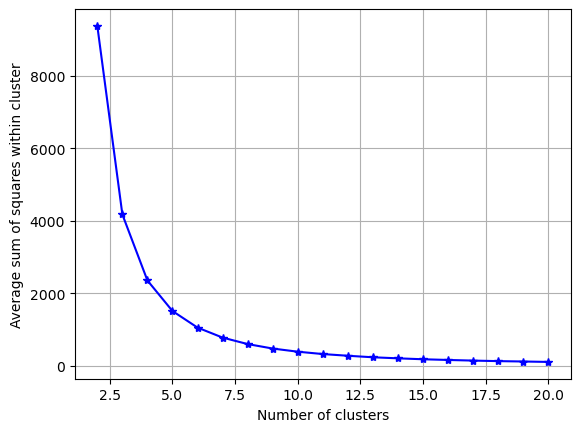

In [38]:
# k_algs, k_res = elbow_method(kmeans_df, 2, 20)
k_algs, k_res = elbow_method(kmeans_new.drop(['Consumption Category', 'Generator Capacity','Postcode'], axis = 1),2,20)

In [39]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[3]

In [40]:
clustering.cluster_centers_

array([[3.05000000e+01, 2.13705746e-01, 1.87291485e-01, 1.70605573e-01,
        1.61859966e-01, 1.53129603e-01, 1.51212313e-01, 1.58694488e-01,
        1.56858963e-01, 1.60408757e-01, 1.66441468e-01, 1.95523734e-01,
        2.11369271e-01, 2.37181893e-01, 2.76213528e-01, 3.03356274e-01,
        3.04097501e-01, 2.97253729e-01, 2.91088240e-01, 2.82140069e-01,
        2.72306988e-01, 2.79122057e-01, 2.79288914e-01, 2.80775493e-01,
        2.81050174e-01, 2.79611395e-01, 2.88192896e-01, 2.80841381e-01,
        2.89602847e-01, 2.88625734e-01, 2.98216246e-01, 3.02431591e-01,
        3.11239328e-01, 3.30373132e-01, 3.74502950e-01, 4.37978924e-01,
        5.07643503e-01, 5.32774521e-01, 5.18477979e-01, 4.93962463e-01,
        4.73511800e-01, 4.60991307e-01, 4.42223077e-01, 4.06327067e-01,
        3.72874266e-01, 3.52175466e-01, 3.30037522e-01, 2.99932205e-01,
        2.55781859e-01],
       [1.51500000e+02, 2.36792055e-01, 2.06469498e-01, 1.90353059e-01,
        1.83020320e-01, 1.82551416e-01,

In [41]:
# cls_list = algorithm.predict(kmeans_df)
cls_list = algorithm.predict(kmeans_new.drop(['Consumption Category', 'Generator Capacity','Postcode'], axis = 1))
cls_list


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [42]:
kmeans_new['cluster'] = cls_list

In [43]:
kmeans_new

,Customer,Consumption Category,Generator Capacity,Postcode,0:30,1:00,1:30,2:00,2:30,3:00,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,cluster
1,1,GC,3.78,2076.0,0.237205,0.228825,0.220693,0.215778,0.203636,0.248071,...,0.259647,0.255167,0.251351,0.254436,0.220027,0.232636,0.687721,0.657704,0.250784,0
4,2,GC,1.62,2259.0,0.210183,0.185327,0.178704,0.166176,0.166831,0.154366,...,0.598092,0.582662,0.552239,0.497651,0.463067,0.390996,0.331873,0.285930,0.247021,0
7,3,GC,1.00,2263.0,0.146493,0.116430,0.097466,0.080526,0.067989,0.066044,...,0.175036,0.167860,0.170849,0.174556,0.170101,0.182595,0.169345,0.142052,0.140025,0
10,4,GC,1.00,2220.0,0.122540,0.114627,0.109523,0.109726,0.106537,0.107447,...,0.363274,0.344773,0.308729,0.288553,0.252748,0.215800,0.197874,0.167203,0.141532,0
13,5,GC,1.00,2261.0,0.131244,0.122945,0.119326,0.115562,0.115000,0.113329,...,0.421499,0.415660,0.390816,0.352205,0.306803,0.245762,0.220088,0.182849,0.152159,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,296,GC,1.08,2087.0,0.062085,0.057603,0.056137,0.053951,0.052975,0.051712,...,0.183652,0.171753,0.167400,0.157918,0.141907,0.115573,0.097901,0.081208,0.068929,2
729,297,GC,1.50,2261.0,0.217375,0.210674,0.207096,0.199477,0.195803,0.183701,...,0.460101,0.376121,0.307263,0.269342,0.243123,0.227227,0.222282,0.220400,0.216586,2
731,298,GC,1.02,2216.0,0.125789,0.108455,0.094803,0.088608,0.082173,0.081405,...,0.354395,0.335290,0.314641,0.281786,0.253211,0.225811,0.195197,0.166085,0.146282,2
733,299,GC,1.00,2076.0,0.259118,0.220315,0.206156,0.195871,0.197208,0.195600,...,0.934290,0.933523,0.935263,0.881537,0.772164,0.672515,0.517504,0.394515,0.322016,2


In [44]:
def print_building_types_in_clusters(data):
    for tp in data['Customer'].unique():
        print('How many buildings of type', tp, 'are in each cluster?')
        print(data[data.Customer == tp]['cluster'].value_counts())

In [45]:
print_building_types_in_clusters(kmeans_new)

How many buildings of type 1 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 2 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 3 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 4 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 5 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 6 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 7 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 8 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 9 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 10 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 11 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 12 are in each cluster?
0    1
Name:

3    1
Name: cluster, dtype: int64
How many buildings of type 110 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 111 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 112 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 113 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 114 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 115 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 116 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 117 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 118 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 119 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 120 are in each cluster?
3    1
Name: cluster, dtype: int64
How many

4    1
Name: cluster, dtype: int64
How many buildings of type 237 are in each cluster?
4    1
Name: cluster, dtype: int64
How many buildings of type 238 are in each cluster?
4    1
Name: cluster, dtype: int64
How many buildings of type 239 are in each cluster?
4    1
Name: cluster, dtype: int64
How many buildings of type 240 are in each cluster?
4    1
Name: cluster, dtype: int64
How many buildings of type 241 are in each cluster?
4    1
Name: cluster, dtype: int64
How many buildings of type 242 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 243 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 244 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 245 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 246 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 247 are in each cluster?
2    1
Name: cluster, dtype: int64
How many

In [107]:
def clusters_visualisation(kmeans_df, id_vars, value_vars):
    melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
    clusters = kmeans_df['cluster'].unique()
    clusters.sort()
    for c in clusters:
        avg = melt_df[melt_df.cluster == c]
        avg['hour'] = pd.to_datetime(avg['hour']).dt.time
        # Sort the DataFrame based on the 'hour' column
        avg = avg.sort_values(by='hour')
        data = avg.groupby(id_vars)
        multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

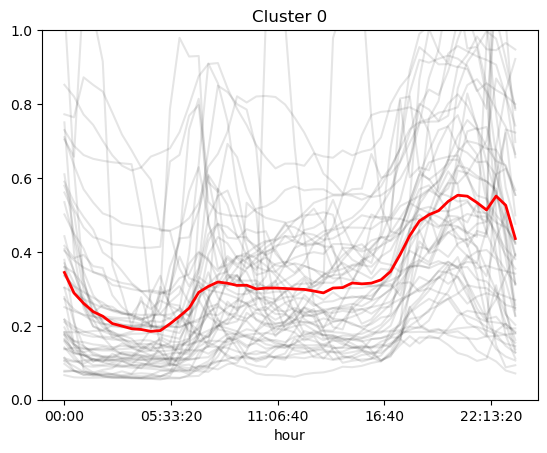

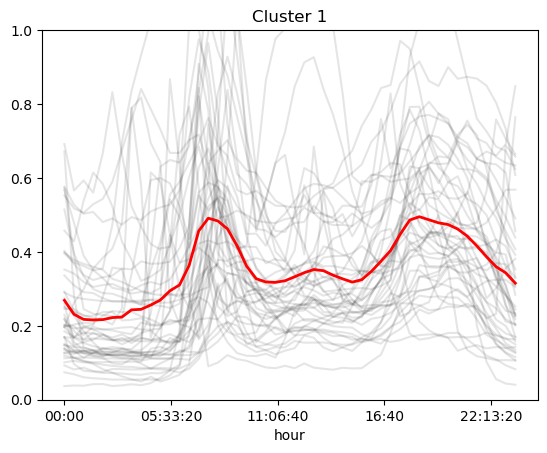

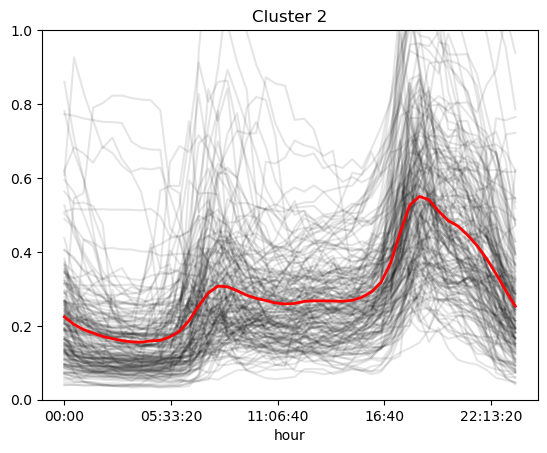

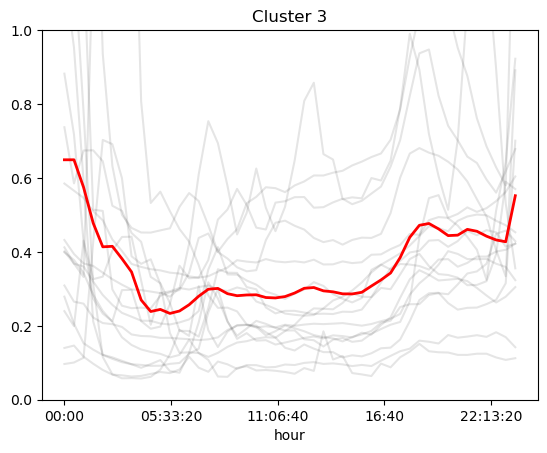

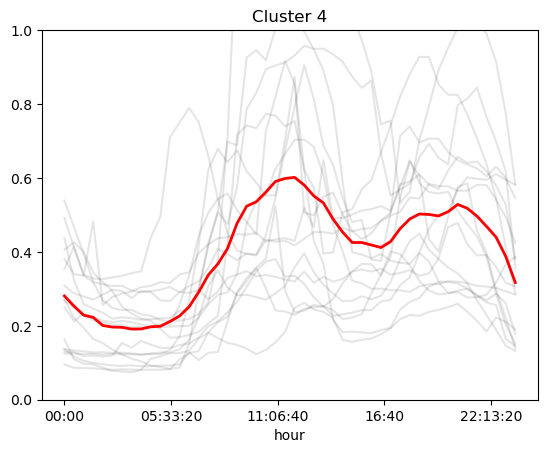

In [108]:
clusters_visualisation(kmeans_new, id_vars = ['Customer', 'cluster','Consumption Category'], value_vars = list(kmeans_new.columns[4:53]))

In [48]:
kmeans_new_CL = df_new[df_new['Consumption Category']=='CL']

kmeans_new_CL

,Customer,Consumption Category,Generator Capacity,Postcode,0:30,1:00,1:30,2:00,2:30,3:00,...,19:30,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00
0,1,CL,3.78,2076.0,0.614929,1.112455,1.035203,0.679364,0.557608,0.510868,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.537266
3,2,CL,1.62,2259.0,0.054637,0.049278,0.017968,0.042324,0.015528,0.025648,...,0.009151,0.020204,0.990898,0.259229,0.069461,0.026088,0.030764,0.037289,0.039796,0.022303
6,3,CL,1.00,2263.0,0.206671,0.197488,0.142126,0.071049,0.041090,0.011759,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000003,0.000000,0.000000,0.000000,0.000000
9,4,CL,1.00,2220.0,0.000000,0.000000,0.996329,0.639405,1.201277,0.552096,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
12,5,CL,1.00,2261.0,0.694233,0.501770,0.349016,0.261449,0.190203,0.163203,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.007940,0.858556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
711,290,CL,1.05,2282.0,0.965156,0.540027,0.228090,0.085219,0.029049,0.004863,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.900847,0.763274
718,293,CL,1.05,2290.0,1.009505,1.631703,1.325505,0.799962,0.356543,0.127009,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.048902
721,294,CL,1.10,2228.0,0.000000,0.952394,1.773821,1.359355,0.855101,0.535339,...,0.000000,0.003274,0.005130,0.003176,0.002919,0.000000,0.002687,0.002984,0.000000,0.000000
728,297,CL,1.50,2261.0,0.009830,0.034548,0.148408,0.351970,0.367441,0.215279,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.794003,2.090208,0.341923,0.016367


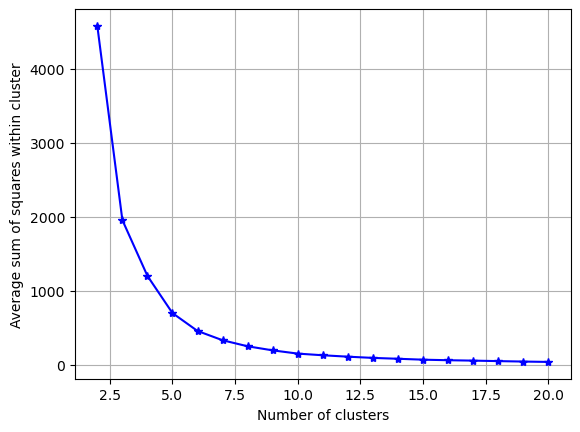

In [49]:
k_algs, k_res = elbow_method(kmeans_new_CL.drop(['Consumption Category', 'Generator Capacity','Postcode'], axis = 1),2,20)

In [50]:
algorithm = k_algs[3] # Values of k are {2, 3, 4, 5, ..., 20} so k = 6 corresponds to the element with index 4
clustering = k_res[3]

In [51]:
clustering.cluster_centers_

array([[7.98666667e+01, 4.82020189e-01, 5.28438212e-01, 5.13463595e-01,
        3.66503086e-01, 2.42970441e-01, 1.27470587e-01, 8.27374805e-02,
        7.49428661e-02, 7.32108980e-02, 6.69197602e-02, 5.71622839e-02,
        5.52982113e-02, 8.43428710e-02, 1.06233717e-01, 6.93161538e-02,
        7.49197092e-02, 6.98597416e-02, 8.22670594e-02, 8.23055967e-02,
        7.12095799e-02, 5.92419741e-02, 5.31856514e-02, 4.48450091e-02,
        3.97632207e-02, 3.83088858e-02, 3.76300533e-02, 3.42452131e-02,
        3.15369254e-02, 2.70379970e-02, 2.67135738e-02, 2.77598554e-02,
        2.53517610e-02, 2.84504368e-02, 2.42657230e-02, 1.75216073e-02,
        2.27972466e-02, 1.59202755e-02, 1.47998828e-02, 1.34579056e-02,
        1.47040989e-02, 1.17723546e-02, 1.15296606e-02, 1.22154825e-02,
        1.96647519e-02, 1.11548830e-01, 6.64660350e-02, 1.77923377e-01,
        3.54200289e-01],
       [2.72357143e+02, 5.66170524e-01, 6.27330919e-01, 5.26971848e-01,
        4.56404151e-01, 2.36784632e-01,

In [52]:
cls_list = algorithm.predict(kmeans_new_CL.drop(['Consumption Category', 'Generator Capacity','Postcode'], axis = 1))
cls_list


array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1])

In [72]:
# print_building_types_in_clusters(kmeans_new_CL)

In [55]:
# clusters_visualisation(kmeans_new_CL, id_vars = ['Customer', 'cluster'], value_vars = list(kmeans_new.columns[4:52]))

In [56]:
cluster = pd.read_csv('output.csv')
cluster


,Customer,max_time,max_con,minutes_since_midnight,clusters
0,1,05:30,1.320876,330,1
1,2,18:30,1.004222,1110,2
2,3,00:30,0.641370,30,3
3,4,18:00,0.424977,1080,2
4,5,18:30,1.417480,1110,2
...,...,...,...,...,...
295,296,18:30,0.830517,1110,2
296,297,19:30,0.783600,1170,2
297,298,19:00,0.516500,1140,2
298,299,19:00,2.339083,1140,2


In [57]:
cluster = cluster['clusters'].tolist()

In [58]:
cluster


[1,
 2,
 3,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 4,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 2,
 2,
 2,
 0,
 2,
 0,
 2,
 3,
 2,
 2,
 0,
 1,
 1,
 0,
 2,
 2,
 2,
 4,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 4,
 2,
 0,
 3,
 1,
 2,
 1,
 0,
 2,
 2,
 0,
 0,
 1,
 4,
 0,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 3,
 2,
 1,
 2,
 2,
 0,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 0,
 3,
 2,
 4,
 3,
 2,
 2,
 2,
 1,
 2,
 2,
 4,
 0,
 2,
 0,
 2,
 2,
 1,
 2,
 0,
 4,
 4,
 2,
 2,
 1,
 2,
 2,
 2,
 2,
 0,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 0,
 0,
 0,
 1,
 0,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 0,
 2,
 0,
 2,
 1,
 2,
 2,
 2,
 2,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 3,
 2,
 2,
 4,
 2,
 2,
 2,
 0,
 2,
 2,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 4,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 2,
 3,
 0,
 2,
 0,
 0,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 4,
 0,
 0,
 1,
 2,
 4,
 3,
 2,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 2,
 2,
 2,
 2,
 3,
 1,
 4,


In [59]:
kmeans_new['cluster'] = cluster

In [60]:
kmeans_new

,Customer,Consumption Category,Generator Capacity,Postcode,0:30,1:00,1:30,2:00,2:30,3:00,...,20:00,20:30,21:00,21:30,22:00,22:30,23:00,23:30,0:00,cluster
1,1,GC,3.78,2076.0,0.237205,0.228825,0.220693,0.215778,0.203636,0.248071,...,0.259647,0.255167,0.251351,0.254436,0.220027,0.232636,0.687721,0.657704,0.250784,1
4,2,GC,1.62,2259.0,0.210183,0.185327,0.178704,0.166176,0.166831,0.154366,...,0.598092,0.582662,0.552239,0.497651,0.463067,0.390996,0.331873,0.285930,0.247021,2
7,3,GC,1.00,2263.0,0.146493,0.116430,0.097466,0.080526,0.067989,0.066044,...,0.175036,0.167860,0.170849,0.174556,0.170101,0.182595,0.169345,0.142052,0.140025,3
10,4,GC,1.00,2220.0,0.122540,0.114627,0.109523,0.109726,0.106537,0.107447,...,0.363274,0.344773,0.308729,0.288553,0.252748,0.215800,0.197874,0.167203,0.141532,2
13,5,GC,1.00,2261.0,0.131244,0.122945,0.119326,0.115562,0.115000,0.113329,...,0.421499,0.415660,0.390816,0.352205,0.306803,0.245762,0.220088,0.182849,0.152159,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,296,GC,1.08,2087.0,0.062085,0.057603,0.056137,0.053951,0.052975,0.051712,...,0.183652,0.171753,0.167400,0.157918,0.141907,0.115573,0.097901,0.081208,0.068929,2
729,297,GC,1.50,2261.0,0.217375,0.210674,0.207096,0.199477,0.195803,0.183701,...,0.460101,0.376121,0.307263,0.269342,0.243123,0.227227,0.222282,0.220400,0.216586,2
731,298,GC,1.02,2216.0,0.125789,0.108455,0.094803,0.088608,0.082173,0.081405,...,0.354395,0.335290,0.314641,0.281786,0.253211,0.225811,0.195197,0.166085,0.146282,2
733,299,GC,1.00,2076.0,0.259118,0.220315,0.206156,0.195871,0.197208,0.195600,...,0.934290,0.933523,0.935263,0.881537,0.772164,0.672515,0.517504,0.394515,0.322016,2


In [61]:
def print_building_types_in_clusters(data):
    for tp in data['Customer'].unique():
        print('How many buildings of type', tp, 'are in each cluster?')
        print(data[data.Customer == tp]['cluster'].value_counts())

In [62]:
print_building_types_in_clusters(kmeans_new)

How many buildings of type 1 are in each cluster?
1    1
Name: cluster, dtype: int64
How many buildings of type 2 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 3 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 4 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 5 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 6 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 7 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 8 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 9 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 10 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 11 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 12 are in each cluster?
2    1
Name:

2    1
Name: cluster, dtype: int64
How many buildings of type 212 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 213 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 214 are in each cluster?
1    1
Name: cluster, dtype: int64
How many buildings of type 215 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 216 are in each cluster?
3    1
Name: cluster, dtype: int64
How many buildings of type 217 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 218 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 219 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 220 are in each cluster?
0    1
Name: cluster, dtype: int64
How many buildings of type 221 are in each cluster?
2    1
Name: cluster, dtype: int64
How many buildings of type 222 are in each cluster?
2    1
Name: cluster, dtype: int64
How many

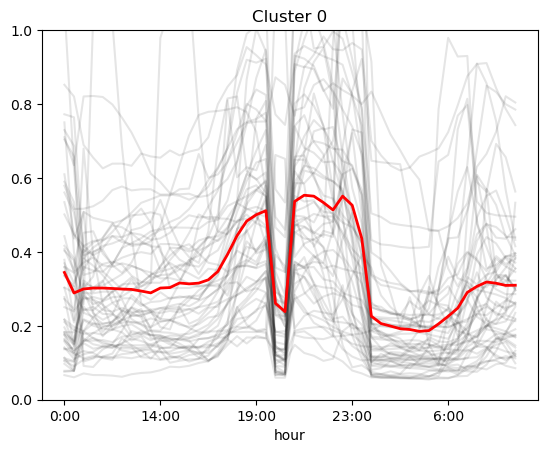

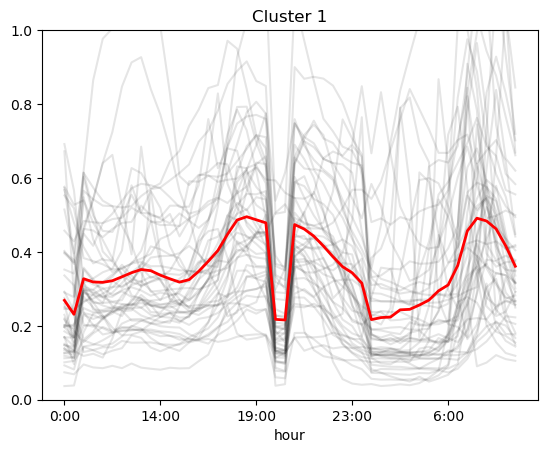

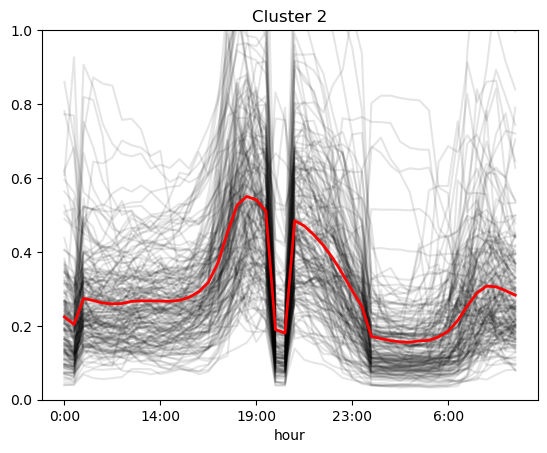

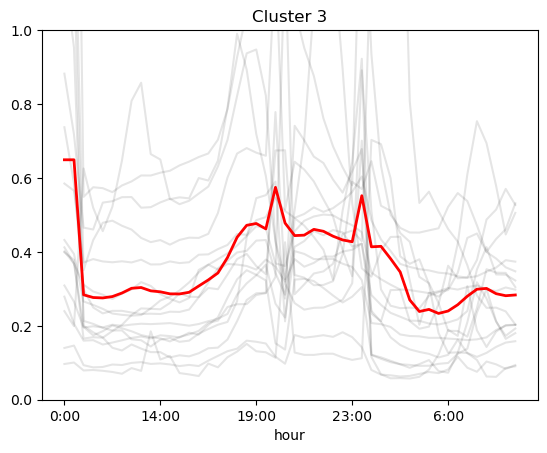

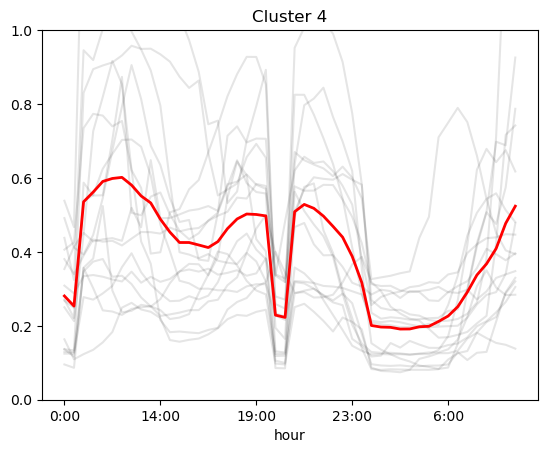

In [63]:
clusters_visualisation(kmeans_new, id_vars = ['Customer', 'cluster','Consumption Category'], value_vars = list(kmeans_new.columns[4:52]))

In [64]:
melt_df = pd.melt(kmeans_new, id_vars = ['Customer', 'cluster','Consumption Category'], value_vars =  list(kmeans_new.columns[4:53]), var_name = 'hour', value_name = 'norm_energy')

In [65]:
melt_df

,Customer,cluster,Consumption Category,hour,norm_energy
0,1,1,GC,0:30,0.237205
1,2,2,GC,0:30,0.210183
2,3,3,GC,0:30,0.146493
3,4,2,GC,0:30,0.122540
4,5,2,GC,0:30,0.131244
...,...,...,...,...,...
14395,296,2,GC,0:00,0.068929
14396,297,2,GC,0:00,0.216586
14397,298,2,GC,0:00,0.146282
14398,299,2,GC,0:00,0.322016


In [66]:
avg = melt_df[melt_df.cluster == 0]

In [97]:
avg

,Customer,cluster,Consumption Category,hour,norm_energy
6,7,0,GC,0:30,0.129422
37,38,0,GC,0:30,0.079088
47,48,0,GC,0:30,0.182444
49,50,0,GC,0:30,0.078816
54,55,0,GC,0:30,0.534507
...,...,...,...,...,...
14360,261,0,GC,0:00,0.216989
14361,262,0,GC,0:00,0.358501
14367,268,0,GC,0:00,0.141597
14368,269,0,GC,0:00,0.729504


In [68]:
value_vars =  list(kmeans_new.columns[4:52])
id_vars = ['Customer', 'cluster','Consumption Category']
len(value_vars)
value_vars
id_vars

['Customer', 'cluster', 'Consumption Category']

In [69]:
# value_vars =  list(kmeans_new.columns[4:53])
data = avg.groupby(id_vars)

In [70]:
print(data)

In [73]:
# # def multiline_hourly_plot(dataset, avg = None, ycol = 'energy', ymin = None, ymax = None, opacity = None, title = None):
# #     fig, ax = plt.subplots()
    
# #     if ymin is not None:
# #         ax.set_ylim(bottom = ymin)
    
# #     if ymax is not None:
# #         ax.set_ylim(top = ymax)
        
# #     if opacity is None:
# #         opacity = 0.01

# #     for key, group in dataset:
# #         ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
    
# #     if avg is not None:
# #         ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
        
# #     if title is not None:
# #         ax.set_title(title)

# #     ax.legend().set_visible(False) # Disable the plot legend
# #     plt.show()



# def clusters_visualisation(kmeans_df, id_vars, value_vars):
#     melt_df = pd.melt(kmeans_df, id_vars = id_vars, value_vars = value_vars, var_name = 'hour', value_name = 'norm_energy')
#     clusters = kmeans_df['cluster'].unique()
#     clusters.sort()
#     for c in clusters:
#         avg = melt_df[melt_df.cluster == c]
#         data = avg.groupby(id_vars)
#         multiline_hourly_plot(data, avg = avg, ymin = 0, ycol = 'norm_energy', opacity = 0.1, title = 'Cluster ' + str(c))

In [77]:
clusters = kmeans_new['cluster'].unique()
clusters.sort()


In [89]:
avg = melt_df[melt_df.cluster == 0]
data = avg.groupby(id_vars)
ycol = 'norm_energy'
opacity = 0.1

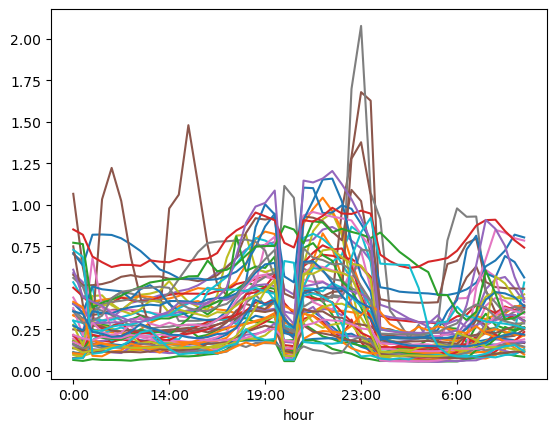

In [96]:
fig, ax = plt.subplots()
for key, group in data:
        ax = group.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#000000', alpha = opacity)
# if avg is not None:
#        ax = avg.groupby('hour').mean().plot(ax = ax, y = ycol, color = '#FF0000', alpha = 1, linewidth = 2)
ax.legend().set_visible(False) # Disable the plot legend
plt.show()

In [98]:
new_avg = avg

In [105]:
new_avg['hour'] = pd.to_datetime(new_avg['hour']).dt.time

# Sort the DataFrame based on the 'hour' column
avg_sorted = new_avg.sort_values(by='hour')

# Display the sorted DataFrame
print(avg_sorted)

       Customer  cluster Consumption Category      hour  norm_energy
14390       291        0                   GC  00:00:00     0.359507
14245       146        0                   GC  00:00:00     0.066532
14235       136        0                   GC  00:00:00     0.334885
14230       131        0                   GC  00:00:00     0.710175
14228       129        0                   GC  00:00:00     0.302384
...         ...      ...                  ...       ...          ...
13964       165        0                   GC  23:30:00     0.093359
13963       164        0                   GC  23:30:00     0.226318
13958       159        0                   GC  23:30:00     0.722827
14018       219        0                   GC  23:30:00     0.180389
13806         7        0                   GC  23:30:00     0.193101

[2448 rows x 5 columns]


In [106]:
avg_sorted

,Customer,cluster,Consumption Category,hour,norm_energy
14390,291,0,GC,00:00:00,0.359507
14245,146,0,GC,00:00:00,0.066532
14235,136,0,GC,00:00:00,0.334885
14230,131,0,GC,00:00:00,0.710175
14228,129,0,GC,00:00:00,0.302384
...,...,...,...,...,...
13964,165,0,GC,23:30:00,0.093359
13963,164,0,GC,23:30:00,0.226318
13958,159,0,GC,23:30:00,0.722827
14018,219,0,GC,23:30:00,0.180389
